Person of Interests Identification in Enron Scandal
---------------------------------------------------
In 2002, Enron had collapsed into bankruptcy due to widespread corporate fraud. Duuring the federal investigation, there was a significant amount of confidential data that made public, including tens of thousands emails and detailed financial data for top executives. In this project, I will build a person of interest identifier based on the public available financial and email data.

The Dataset Mapping
-------------------
(1) ['poi']
(2) financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus','restricted_stock_deferred','deferred_income','total_stock_value', 'expenses', 'exercised_stock_options', 'other','long_term_incentive', 'restricted_stock', 'director_fees']
(3) email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

In [67]:
import sys
import pickle
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../tools/')
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

Task1: Select what features you'll use.
---------------------------------------
features_list is a list of strings, each of which is a feature name.
the frist feature must be 'poi'.


In [68]:
features_list = ['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred',\
                 'deferred_income','total_stock_value', 'expenses', 'exercised_stock_options', 'other',\
                 'long_term_incentive', 'restricted_stock', 'director_fees',\
                 'to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi',\
                 'shared_receipt_with_poi']  # You will need to use more features  
### Load the dictionary containing the dataset and save it as a python dictionary                                                                                                   
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    

In [69]:
print data_dict['METTS MARK']


{'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}


We will reformat data into pandas dataframe.


In [70]:
df = pd.DataFrame.from_records(list(data_dict.values()))
names = pd.Series(list(data_dict.keys()))
print df.head()

     bonus deferral_payments deferred_income director_fees  \
0   600000               NaN             NaN           NaN   
1  1200000           1295738        -1386055           NaN   
2   350000               NaN         -400729           NaN   
3      NaN               NaN             NaN           NaN   
4  1500000               NaN        -3117011           NaN   

              email_address exercised_stock_options expenses from_messages  \
0      mark.metts@enron.com                     NaN    94299            29   
1                       NaN                 6680544    11200           NaN   
2  steven.elliott@enron.com                 4890344    78552           NaN   
3     bill.cordes@enron.com                  651850      NaN            12   
4    kevin.hannon@enron.com                 5538001    34039            32   

  from_poi_to_this_person from_this_person_to_poi        ...         \
0                      38                       1        ...          
1               

We need to do data cleaning before starting analyzing any features. 
First, we look at how many NaN in each features.

In [71]:
allfeatures = ['poi','salary','to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options',\
                 'bonus', 'restricted_stock','restricted_stock_deferred', 'loan_advances',\
                'deferred_income','total_stock_value', 'expenses', 'other', 'long_term_incentive',\
                 'director_fees', 'from_poi_to_this_person', 'from_messages',\
                'from_this_person_to_poi','shared_receipt_with_poi', 'email_address'] 
# convert NaN to numpy nan
df.replace(to_replace="NaN",value=np.nan,inplace=True)

# count number of NaN's for columns
print df.isnull().sum()

# DataFrame dimension
print df.shape
#ct = [0]*21
#for name in data_dict:
#    for feature in range(0,21):
#        if data_dict[name][allfeatures[feature]]!='NaN':
#            ct[feature]+=1
#print "Numbers of non NaN data in each feature?"
#for feature in range(0,21):
#    print ct[feature],'\t',allfeatures[feature]
            

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                 35
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64
(146, 21)


We can see that all features have missing elements. Let's drop the features with <=65 (can be tuned) non NaN elements

In [72]:
for column, series in df.iteritems():
    if series.isnull().sum()>65:
        df.drop(column,axis=1,inplace=True)

#drop_list = []
#for feature in range(0,21):
#    if ct[feature]<=80:
#        temp=allfeatures[feature]
#        drop_list.append(temp)
        
#print len(drop_list),drop_list
#for drop in range(len(drop_list)):
#    if drop_list[drop] in list(df.columns.values):
#        df.drop(drop_list[drop],axis=1,inplace=True)

if 'email_address' in list(df.columns.values):
    df.drop(['email_address'],axis=1,inplace=True)
print df.head()

       bonus  exercised_stock_options  expenses  from_messages  \
0   600000.0                      NaN   94299.0           29.0   
1  1200000.0                6680544.0   11200.0            NaN   
2   350000.0                4890344.0   78552.0            NaN   
3        NaN                 651850.0       NaN           12.0   
4  1500000.0                5538001.0   34039.0           32.0   

   from_poi_to_this_person  from_this_person_to_poi      other    poi  \
0                     38.0                      1.0     1740.0  False   
1                      NaN                      NaN  2660303.0  False   
2                      NaN                      NaN    12961.0  False   
3                     10.0                      0.0        NaN  False   
4                     32.0                     21.0    11350.0   True   

   restricted_stock    salary  shared_receipt_with_poi  to_messages  \
0          585062.0  365788.0                    702.0        807.0   
1         3942714.0  2

Let's deal with NaN and outliers

In [73]:
df_imp=df.replace(to_replace=np.nan,value=0)
df_imp = df.fillna(0).copy(deep=True)
print df_imp.isnull().sum()
df_imp.describe()

bonus                      0
exercised_stock_options    0
expenses                   0
from_messages              0
from_poi_to_this_person    0
from_this_person_to_poi    0
other                      0
poi                        0
restricted_stock           0
salary                     0
shared_receipt_with_poi    0
to_messages                0
total_payments             0
total_stock_value          0
dtype: int64


,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,146.000000,1.460000e+02,1.460000e+02
mean,1.333474e+06,4.182736e+06,7.074827e+04,358.602740,38.226027,24.287671,5.854318e+05,1.749257e+06,3.658114e+05,692.986301,1221.589041,4.350622e+06,5.846018e+06
std,8.094029e+06,2.607040e+07,4.327163e+05,1441.259868,73.901124,79.278206,3.682345e+06,1.089995e+07,2.203575e+06,1072.969492,2226.770637,2.693448e+07,3.624681e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,8.115000e+03,0.000000e+00,0.000000,0.000000,9.394475e+04,2.288695e+05
50%,3.000000e+05,6.082935e+05,2.018200e+04,16.500000,2.500000,0.000000,9.595000e+02,3.605280e+05,2.105960e+05,102.500000,289.000000,9.413595e+05,9.659550e+05
75%,8.000000e+05,1.714221e+06,5.374075e+04,51.250000,40.750000,13.750000,1.506065e+05,8.145280e+05,2.708505e+05,893.500000,1585.750000,1.968287e+06,2.319991e+06
max,9.734362e+07,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,4.266759e+07,1.303223e+08,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


By comparing the max and .75 quantile, we can figure out whether there are outliers. It's not very clear so let's explore the names.

In [74]:
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

Let's remove 'TOTAL' and 'The TRAVEL AGENCY IN THE PARK'.

Task2: Remove outliers
----------------------


In [75]:
total_ind = data_dict.keys().index('TOTAL')
travel_ind = data_dict.keys().index('THE TRAVEL AGENCY IN THE PARK')
df_sub=df_imp.drop(df_imp.index[[total_ind,travel_ind]])
df_sub.describe()

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.440000e+02,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02
mean,6.759974e+05,2.075802e+06,35375.340278,363.583333,38.756944,24.625000,2.947455e+05,8.685363e+05,1.854460e+05,702.611111,1238.555556,2.256543e+06,2.909786e+06
std,1.233155e+06,4.795513e+06,45309.303038,1450.675239,74.276769,79.778266,1.131325e+06,2.016572e+06,1.970421e+05,1077.290736,2237.564816,8.847189e+06,6.189018e+06
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.434500e+04,0.000000e+00,0.000000,0.000000,9.019275e+04,2.443265e+05
50%,3.000000e+05,6.082935e+05,20182.000000,17.500000,4.000000,0.000000,9.190000e+02,3.605280e+05,2.105960e+05,114.000000,347.500000,9.413595e+05,9.659550e+05
75%,8.000000e+05,1.683580e+06,53328.250000,53.000000,41.250000,14.000000,1.485770e+05,7.374560e+05,2.696675e+05,933.750000,1623.000000,1.945668e+06,2.295176e+06
max,8.000000e+06,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,1.035973e+07,1.476169e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


After our feature engineering, let's explore what values do we have and data dimension


In [76]:
print "features:", list(df_sub.columns.values)
print "Shape:", df_sub.shape
print "Number of POI in the dataset:", (df_sub['poi']==1).sum()
print "Number of non-POI in the dataset:", (df_sub['poi']==0).sum()


features: ['bonus', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other', 'poi', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']
Shape: (144, 14)
Number of POI in the dataset: 18
Number of non-POI in the dataset: 126


Task 3: Creating new features
---------------------
Feature engineering is something that I have to continue learning. One of the useful feature might be the ratio between messages connected with poi and all messages. The new variable is renamed, 'poi_ratio'. 

Features are also added, including,
- the fraction of all emails to a person that were sent from a POI
- the fraction of all emails that a person sent that were addressed to POIs

The hypothesis of these new features is that there might be higher correlation between POIs than that between POIs and non-POIs. To visidualize it, a scatter plot is used.

Additionally, I will scale 'salary' to range [0,100] because the feature that I selected have different units

In [77]:
poi_ratio = (df_sub['from_poi_to_this_person']+df_sub['from_this_person_to_poi'])/ \
(df_sub['from_messages']+df_sub['to_messages'])

fraction_to_poi =(df_sub['from_this_person_to_poi'])/(df_sub['from_messages'])
fraction_from_poi = (df_sub['from_poi_to_this_person'])/(df_sub['to_messages'])
df_sub['fraction_to_poi'] = pd.Series(fraction_to_poi)*100
df_sub['fraction_from_poi']=pd.Series(fraction_from_poi)*100
df_sub.describe()

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,fraction_to_poi,fraction_from_poi
count,1.440000e+02,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02,86.000000,86.000000
mean,6.759974e+05,2.075802e+06,35375.340278,363.583333,38.756944,24.625000,2.947455e+05,8.685363e+05,1.854460e+05,702.611111,1238.555556,2.256543e+06,2.909786e+06,18.405548,3.796298
std,1.233155e+06,4.795513e+06,45309.303038,1450.675239,74.276769,79.778266,1.131325e+06,2.016572e+06,1.970421e+05,1077.290736,2237.564816,8.847189e+06,6.189018e+06,21.061035,4.054439
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.434500e+04,0.000000e+00,0.000000,0.000000,9.019275e+04,2.443265e+05,1.242096,0.919988
50%,3.000000e+05,6.082935e+05,20182.000000,17.500000,4.000000,0.000000,9.190000e+02,3.605280e+05,2.105960e+05,114.000000,347.500000,9.413595e+05,9.659550e+05,10.057359,2.584537
75%,8.000000e+05,1.683580e+06,53328.250000,53.000000,41.250000,14.000000,1.485770e+05,7.374560e+05,2.696675e+05,933.750000,1623.000000,1.945668e+06,2.295176e+06,27.203947,5.608871
max,8.000000e+06,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,1.035973e+07,1.476169e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07,100.000000,21.734104


In [78]:
# salary scaling
from sklearn.preprocessing import MinMaxScaler
scaler_salary = MinMaxScaler(feature_range=(0, 100), copy=True)
salary_scaled= scaler_salary.fit_transform(df_sub['salary'].astype(float))
df_sub['scaled_salary'] = pd.Series(salary_scaled)
df_sub.describe()

/Users/yuchengtsai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yuchengtsai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,fraction_to_poi,fraction_from_poi,scaled_salary
count,1.440000e+02,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02,86.000000,86.000000,142.000000
mean,6.759974e+05,2.075802e+06,35375.340278,363.583333,38.756944,24.625000,2.947455e+05,8.685363e+05,1.854460e+05,702.611111,1238.555556,2.256543e+06,2.909786e+06,18.405548,3.796298,16.758214
std,1.233155e+06,4.795513e+06,45309.303038,1450.675239,74.276769,79.778266,1.131325e+06,2.016572e+06,1.970421e+05,1077.290736,2237.564816,8.847189e+06,6.189018e+06,21.061035,4.054439,17.792262
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.434500e+04,0.000000e+00,0.000000,0.000000,9.019275e+04,2.443265e+05,1.242096,0.919988,0.000000
50%,3.000000e+05,6.082935e+05,20182.000000,17.500000,4.000000,0.000000,9.190000e+02,3.605280e+05,2.105960e+05,114.000000,347.500000,9.413595e+05,9.659550e+05,10.057359,2.584537,18.951135
75%,8.000000e+05,1.683580e+06,53328.250000,53.000000,41.250000,14.000000,1.485770e+05,7.374560e+05,2.696675e+05,933.750000,1623.000000,1.945668e+06,2.295176e+06,27.203947,5.608871,24.373323
max,8.000000e+06,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,1.035973e+07,1.476169e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07,100.000000,21.734104,100.000000


Visualization
-------------


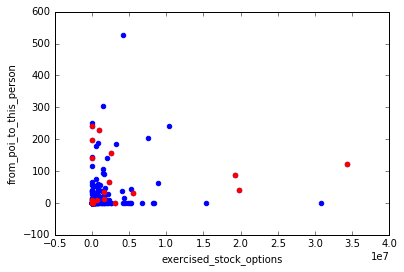

In [79]:
dfeatures = ['poi','exercised_stock_options','from_poi_to_this_person']
def drawXY(df,dfeatures):
    n = len(df)
    X = df[dfeatures[1]]
    Y = df[dfeatures[2]]
    rind = np.nonzero(df[dfeatures[0]])[0]
    plt.scatter(X,Y,color='blue')
    plt.scatter(X[rind],Y[rind],color='red') #if poi, label red
    plt.xlabel(dfeatures[1])
    plt.ylabel(dfeatures[2])
    plt.show()

drawXY(df_sub,dfeatures)

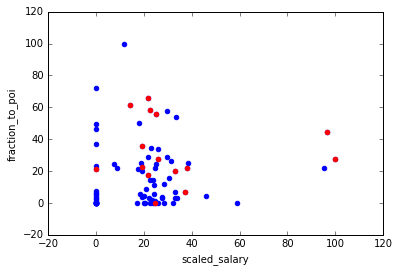

In [80]:
newfeatures = ['poi','scaled_salary','fraction_to_poi']
drawXY(df_sub,newfeatures)

Feature selection
-----------------
Because of the small size of the dataset, I use stratified split cross validation.
Because there are 18 POIs among 146 people, it's important to do stratified k-fold. Otherwise, it's likely to have no POIs in the test set. In stratified k-fold cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds. In the case of a dichotomous classification, this means that each fold contains rougly the same propotions of the two types of class labels.

In [81]:
labels = df_sub['poi'].copy(deep=True).astype(int).as_matrix()
features = df_sub.drop('poi',axis=1).fillna(0).copy(deep=True).as_matrix()
features_list = list(df_sub.columns.values)
print 'features:',df_sub.columns.values

features: ['bonus' 'exercised_stock_options' 'expenses' 'from_messages'
 'from_poi_to_this_person' 'from_this_person_to_poi' 'other' 'poi'
 'restricted_stock' 'salary' 'shared_receipt_with_poi' 'to_messages'
 'total_payments' 'total_stock_value' 'fraction_to_poi' 'fraction_from_poi'
 'scaled_salary']


In [82]:
# decision tree and feature importances
from sklearn.tree import DecisionTreeClassifier
def SelectImportances(features,labels):
    clf = DecisionTreeClassifier(random_state=0)
    clf = clf.fit(features,labels)
    importances = clf.feature_importances_
    imp=zip(features_list,importances)
    imps=sorted(imp,key=lambda x: x[1],reverse=True)
    return imps

SelectImportances(features,labels)

[('exercised_stock_options', 0.25557778667022346),
 ('other', 0.19013605442176873),
 ('expenses', 0.17013963480128894),
 ('total_stock_value', 0.13605442176870772),
 ('salary', 0.11863587540279261),
 ('restricted_stock', 0.042328042328042326),
 ('fraction_from_poi', 0.042328042328042326),
 ('poi', 0.028171268507402945),
 ('total_payments', 0.016628873771730935),
 ('bonus', 0.0),
 ('from_messages', 0.0),
 ('from_poi_to_this_person', 0.0),
 ('from_this_person_to_poi', 0.0),
 ('shared_receipt_with_poi', 0.0),
 ('to_messages', 0.0),
 ('fraction_to_poi', 0.0)]

Feature ranking:
1. feature 1(0.112972)
2. feature 13(0.103490)
3. feature 0(0.082516)
4. feature 12(0.076504)
5. feature 2(0.076320)
6. feature 6(0.070706)
7. feature 9(0.068959)
8. feature 15(0.062780)
9. feature 8(0.061765)
10. feature 11(0.054147)
11. feature 7(0.053671)
12. feature 5(0.045837)
13. feature 14(0.038818)
14. feature 4(0.037880)
15. feature 3(0.026862)
16. feature 10(0.026773)


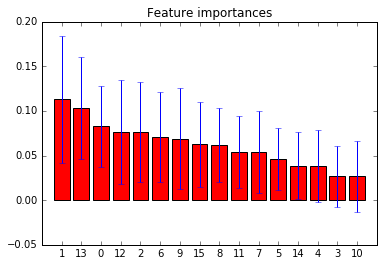

[('exercised_stock_options', 0.11297201009439517),
 ('total_stock_value', 0.10349003367540072),
 ('bonus', 0.082515771978586325),
 ('total_payments', 0.076504051733564185),
 ('expenses', 0.07632013226900583),
 ('other', 0.07070572343116481),
 ('salary', 0.068959028736448588),
 ('fraction_from_poi', 0.062780036621271226),
 ('restricted_stock', 0.061764535825714395),
 ('to_messages', 0.054147056613610293),
 ('poi', 0.053671046825903658),
 ('from_this_person_to_poi', 0.045837174198500003),
 ('fraction_to_poi', 0.038818237163831391),
 ('from_poi_to_this_person', 0.037880189594888515),
 ('from_messages', 0.026862420159060391),
 ('shared_receipt_with_poi', 0.026772551078654516)]

In [83]:
# feature_importances with forests of trees
from sklearn.ensemble import ExtraTreesClassifier

def SelectImportances2(features,labels):
    forest = ExtraTreesClassifier(n_estimators = 50,random_state=0)
    forest = forest.fit(features,labels)
    importances = forest.feature_importances_
    imp=zip(features_list,importances)
    imps=sorted(imp,key=lambda x: x[1],reverse=True)
    
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1] # reverse sort, decending    
    # Print the feature ranking
    print "Feature ranking:"
    for f in range(features.shape[1]):
        print "%d. feature %d(%f)" % (f+1, indices[f], importances[indices[f]])
    #plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(features.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
    plt.xticks(range(features.shape[1]),indices)
    plt.xlim([-1,features.shape[1]])
    plt.show()
    return imps
SelectImportances2(features,labels)

I used forests of trees to evaluate the importances of the features. The top features with most discriminating power includes, 1). exercised_stock_options (0.1129) 2). total_stock_value (0.1034) 3). bonus (0.0825)

Task 4: Try a varity of classifiers                                                                                                          
-----------------------------------
Please name your classifier clf for easy export below.                                                                                       
Note that if you want to do PCA or other multi-stage operations,  
you'll need to use Pipelines. For more info:                                                                                                 
http://scikit-learn.org/stable/modules/pipeline.html
Gaussian Naive Bayes

In [84]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

gnb_clf = GaussianNB()
n_features = features.shape[0]
cv = ShuffleSplit(n_features,n_iter=5,test_size=0.3, random_state=0)
skf = StratifiedKFold(labels,5)
#param_grid=[{'':[],'':[]}]
#gnb_clf = GridSearchCV(GaussianNB(),param_grid,cv=skf,scoring='%s_weighted' %score)
gnb_clf.fit(features,labels)
#print "Best parameters set found on estimators:", clf.best_params_

#for params,mean_score,scores in clf.grid_scores_:
#    print '%0.3f +/- %0.03f for %r' %(mean_score, scores.std()*2, params)

scores = cross_val_score(gnb_clf,features,labels,cv=skf)
print scores
print "Accuracy: %0.3f +/- %0.3f" %(scores.mean(),scores.std()*2) 


[ 0.83333333  0.86206897  0.89655172  0.85714286  0.67857143]
Accuracy: 0.826 +/- 0.152


In [88]:
def scorer(estimator,features_test,labels_test):
    labels_pred = estimator.predict(features_test)
    pre=sklearn.metrics.precision_score(labels_test,labels_pred)
    rec=sklearn.metrics.recall_score(labels_test,labels_pred)
    if pre > 0.3 and rec > 0.3:
        return sklearn.metrics.f1_score(labels_test,labels_pred)
    
    return 0

**Ramdom Forest**

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

#skf = StratifiedKFold(labels,5)
pca = PCA()
RF = RandomForestClassifier()
pipe = Pipeline(steps=[('RF',RF)])
sk_fold =StratifiedShuffleSplit(labels,n_iter=20,test_size=0.1)
param_grid=[{'RF__n_estimators':[5,10],'RF__random_state':[0,1],'RF__max_depth':[2,3,4,5,6],'RF__min_samples_split':[2,3,4,5],'RF__min_samples_leaf':[1,2,3,4],'RF__criterion':('gini','entropy')}]

rf_clf = GridSearchCV(pipe,param_grid,cv=sk_fold,scoring= scorer)
rf_clf.fit(features,labels)
print "Best parameters set found on estimators:", rf_clf.best_params_
print "Best estimators:",rf_clf.best_estimator_
print "Best score:",rf_clf.best_score_

#for params,mean_score,scores in rf_clf.grid_scores_:
#    print '%0.3f +/- %0.03f for %r' %(mean_score, scores.std()*2, params)


Best parameters set found on estimators: {'RF__max_depth': 6, 'RF__n_estimators': 5, 'RF__criterion': 'entropy', 'RF__min_samples_split': 4, 'RF__min_samples_leaf': 1, 'RF__random_state': 0}
Best estimators: Pipeline(steps=[('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])
Best score: 0.403333333333


**K Neighbors** 

In [136]:
from sklearn.neighbors import KNeighborsClassifier
kn=KNeighborsClassifier()
pipe = Pipeline(steps=[('kn',kn)])
sk_fold =StratifiedShuffleSplit(labels,n_iter=100,test_size=0.1)
param_grid=[{'kn__n_neighbors':[5,10],'kn__leaf_size':[30,40],'kn__weights':['uniform','distance'],'kn__p':[1,2]}]

kn_clf = GridSearchCV(pipe,param_grid,cv=sk_fold,scoring= scorer)
kn_clf.fit(features,labels)
print "Best parameters set found on estimators:", kn_clf.best_params_
print "Best estimators:",kn_clf.best_estimator_
print "Best score:",kn_clf.best_score_

Best parameters set found on estimators: {'kn__p': 1, 'kn__n_neighbors': 5, 'kn__leaf_size': 40, 'kn__weights': 'distance'}
Best estimators: Pipeline(steps=[('kn', KNeighborsClassifier(algorithm='auto', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='distance'))])
Best score: 0.320666666667


**AdaBoost**


In [138]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
ada = AdaBoostClassifier()
pca = PCA()
pipe = Pipeline(steps=[('ada',ada)])
sk_fold =StratifiedShuffleSplit(labels,n_iter=100,test_size=0.1)
param_grid=[{'ada__n_estimators':[5,10],'ada__learning_rate':[0.1,0.5,1,1.5,2]}]
ada_clf = GridSearchCV(pipe,param_grid,cv=sk_fold,scoring= scorer)
ada_clf.fit(features,labels)
print "Best parameters set found on estimators:", ada_clf.best_params_
print "Best estimators:",ada_clf.best_estimator_
print "Best score:",ada_clf.best_score_


Best parameters set found on estimators: {'ada__n_estimators': 10, 'ada__learning_rate': 1}
Best estimators: Pipeline(steps=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=10, random_state=None))])
Best score: 0.363380952381


**LogisticRegression**

In [134]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
pipe = Pipeline(steps=[('lr',lr)])
sk_fold =StratifiedShuffleSplit(labels,n_iter=100,test_size=0.1)
param_grid=[{'lr__C':[1,10,100,1000],'lr__class_weight':[{True:12,False:1},{True:10,False:1},{True:8,False:1}]\
           ,'lr__tol':[1e-1,1e-2]}]
lr_clf = GridSearchCV(pipe,param_grid,cv=sk_fold,scoring= scorer)
lr_clf.fit(features,labels)
print "Best parameters set found on estimators:", lr_clf.best_params_
print "Best estimators:",lr_clf.best_estimator_
print "Best score:",lr_clf.best_score_

Best parameters set found on estimators: {'lr__tol': 0.1, 'lr__class_weight': {False: 1, True: 8}, 'lr__C': 1}
Best estimators: Pipeline(steps=[('lr', LogisticRegression(C=1, class_weight={False: 1, True: 8}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False))])
Best score: 0.005


Task5: Test Classifier
---------------
**Random Forest**

In [111]:
from tester import test_classifier
rf_best_clf = rf_clf.best_estimator_
#reformat the DataFrame to dictionary: df_sub
col = list(df_sub.columns.values)
col.remove('poi')
col.insert(0,'poi') # relocate the column 'poi' to the 0th
data = df_sub[col].fillna(0).to_dict(orient='records')
enron_dict={}
ct =0
for line in data:
    enron_dict[ct]=line
    ct+=1

test_classifier(rf_best_clf,enron_dict,col)

Pipeline(steps=[('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])
	Accuracy: 0.85173	Precision: 0.39147	Recall: 0.20200	F1: 0.26649	F2: 0.22365
	Total predictions: 15000	True positives:  404	False positives:  628	False negatives: 1596	True negatives: 12372



**AdaBoost**

In [140]:
from tester import test_classifier
ada_best_clf = ada_clf.best_estimator_
#reformat the DataFrame to dictionary: df_sub
col = list(df_sub.columns.values)
col.remove('poi')
col.insert(0,'poi') # relocate the column 'poi' to the 0th
data = df_sub[col].fillna(0).to_dict(orient='records')
enron_dict={}
ct =0
for line in data:
    enron_dict[ct]=line
    ct+=1

test_classifier(ada_best_clf,enron_dict,col)

Pipeline(steps=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=10, random_state=None))])
	Accuracy: 0.85833	Precision: 0.45401	Recall: 0.30850	F1: 0.36737	F2: 0.32963
	Total predictions: 15000	True positives:  617	False positives:  742	False negatives: 1383	True negatives: 12258



**K Neighbors**

In [137]:
from tester import test_classifier
kn_best_clf = kn_clf.best_estimator_
#reformat the DataFrame to dictionary: df_sub
col = list(df_sub.columns.values)
col.remove('poi')
col.insert(0,'poi') # relocate the column 'poi' to the 0th
data = df_sub[col].fillna(0).to_dict(orient='records')
enron_dict={}
ct =0
for line in data:
    enron_dict[ct]=line
    ct+=1

test_classifier(kn_best_clf,enron_dict,col)

Pipeline(steps=[('kn', KNeighborsClassifier(algorithm='auto', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='distance'))])
	Accuracy: 0.88220	Precision: 0.65850	Recall: 0.24200	F1: 0.35393	F2: 0.27705
	Total predictions: 15000	True positives:  484	False positives:  251	False negatives: 1516	True negatives: 12749



**Logistic Regression**

In [135]:
from tester import test_classifier
lr_best_clf = lr_clf.best_estimator_
#reformat the DataFrame to dictionary: df_sub
col = list(df_sub.columns.values)
col.remove('poi')
col.insert(0,'poi') # relocate the column 'poi' to the 0th
data = df_sub[col].fillna(0).to_dict(orient='records')
enron_dict={}
ct =0
for line in data:
    enron_dict[ct]=line
    ct+=1

test_classifier(lr_best_clf,enron_dict,col)

Pipeline(steps=[('lr', LogisticRegression(C=1, class_weight={False: 1, True: 8}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False))])
	Accuracy: 0.27720	Precision: 0.13893	Recall: 0.85050	F1: 0.23884	F2: 0.42012
	Total predictions: 15000	True positives: 1701	False positives: 10543	False negatives:  299	True negatives: 2457

